# Deep Learning in Medicine
### BMSC-GA 4493, BMIN-GA 3007 
### Homework 4



**Note:** If you need to write mathematical terms, you can type your answeres in a Markdown Cell via LaTex 

See: <a href="https://stackoverflow.com/questions/13208286/how-to-write-latex-in-ipython-notebook">here</a> if you have issues. To see basic LaTex notation see: <a href="https://en.wikibooks.org/wiki/LaTeX/Mathematics"> here </a>.

**Submission instruction**: Upload and Submit your final jupyter notebook with necessary files in <a href='http://newclasses.nyu.edu'>newclasses.nyu.edu</a>. If you use code or script from web, please give a link to the code in your answers.

**Submission deadline:** Saturday May 12th 2018 (5:00 PM)

# Question 1: Literature Review: DeepPatient (Total 25 points + 10 points for Bonus question)

Read this paper:

Riccardo Miotto, Li Li, Brian A. Kidd & Joel T. Dudley, "Deep Patient: An Unsupervised Representation to Predict the Future of Patients from the Electronic Health Records" Scientific Reports, 2016 https://www.nature.com/articles/srep26094.pdf

We are interested in understanding the task, the methods that is proposed in this publication, technical aspects of the implementation, and possible future work. After you read the full article answer the following questions. Describe you answers in your own words.  

### 1.1) (5 points) 
What type of learning algorithm is used (supervised, semi-supervised or unsupervised)? What is the reason for selecting this type of learning algorithm?

Unsupervised (as mentioned on the title :). From the article: "Unsupervised feature learning attempts to overcome limitations of supervised feature space definition by automatically identifying patterns and dependencies in the data to learn a compact and general representation that make it easier to automatically extract useful information when building classifiers or other predictors. Despite the success of feature learning with text, multimedia, and marketing12, as well as the rising popularity of deep learning17 (i.e., learning based on hierarchies of neural networks), these techniques have not been used broadly with EHR data. Here we show that unsupervised deep feature learning applied to pre-process patient-level aggregated EHR data results in representations that are better understood by the machine and significantly improve predictive clinical models for a diverse array of clinical conditions." 

### 1.2) (5 points)
What type of neural network architecture is used in the paper? What is the reason for selecting this type of network?

Stack of denoising encoders. 
"To simulate the presence of missed components in the EHRs (e.g., medications or diagnoses not recorded in the patient records), thus assuming that the input clinical data is a degraded or “noisy” version of the actual clinical situation. All information about those masked components is then removed from that input pattern, and denoising autoencoders can be seen as trained to fill-in these artificially introduced blanks."

### 1.3) (5 points) 
What is the loss function? Whay kind of approaches are used to improve model generalization?

the reconstruction cross-entropy function is used as loss function. 
input corruption via masking algorithm

### 1.4) (5 points) 
How many hidden layers and units does DeepPatient has? What type of activation function is used?

three hidden layers with 500 units in each. sigmoid activation function.

### 1.5) (5 points) 
What are the evaluation metrics used for model comparison? Explain why those metrics were chosen?

the area under the receiver operating characteristic curve (i.e., AUC-ROC), accuracy, and F-score

### 1.6) (Bonus: maximum 10 points) 
How did the authors decide on using specific number of hidden layers in the article? What other architectures would you try?

by evaluating the effect of number of layers to the classification accuracy. Check APPENDIX C.

# Question 2: Transfer learning for disease classification (Total 75 points + 20 points in bonus question)

In this part of the howework, we will revisit the disease classification task we worked on HW2. As opposed to developing our own CNN network as we did on HW2, in this HW we are interested in using transfer learning for the disease classification task.  we will use ResNet50 model to achieve this goal. Here is the link for the ResNet paper: https://arxiv.org/pdf/1512.03385.pdf You will use ResNet50 model as a fixed feature extractor in this question. 

As a reminder: we focused on classifiying the lung disease using chest x-ray dataset provided by NIH (https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community). Please go over the following paper for the details of the dataset: https://arxiv.org/pdf/1705.02315.pdf 

You need to use HPC for training part of this question, as your computer's CPU will not be fast enough to compute learning iterations. In case you use HPC, please have your code/scripts uploaded under the questions and provide the required plots and tables there as well. Data is available in HPC under /beegfs/ga4493/data/HW2 folder. We are interested in classifying infiltration, pneumothorax, cardiomegaly and *not*(infiltration OR pneumothorax OR cardiomegaly) cases. By saying so we have 4 classes that we want to identify by modelling a deep CNN.

Due to time limitations you do not need to your models using the whole dataset, we will use HW2_RandomtrainSet.csv, HW2_testSet.csv and HW2_RandomvalidationSet.csv provided under /beegfs/ga4493/data/HW2 folder for defining train, test and validation set samples that are generated in HW2 Q3.1.
In these .csv files 4 classes were defined as :
- 1 infiltration
- 2 pneumothorax
- 3 cardiomegaly
- 0 for all other diseases (doesnt have infiltration OR pneumothorax OR cardiomegaly) or NoFinding

## 2.1) Define dataloaders for train, test and validations sets
We used Dataset class defined in HW2. Here, we have a copy of it. You need to make necessary changes to make the dataset class is capable of feeding the X-ray dataset into resnet model for transfer learning. Remember X-ray data has grayscale images of 1024x1024 pixels and resnet50 model requires RGB images of size 224x224. Add necessary code to the specified locations: 

### 2.1.a) (10 points) 
Define data transforms required for train and validation/test data

In [1]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color

# multiple ways of doing this, one example would be just resizing the input images
# another one would be use random cropping for data augmentation. 
# torchvision models are trained on input images normalized to [0 1] range .ToPILImage() function achives this
# additional normalization is required see: http://pytorch.org/docs/master/torchvision/models.html

train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        #transforms.Resize([256,256]),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        #transforms.Resize([256,256]),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

class ChestXrayDataset(Dataset):
    """Chest X-ray dataset from https://nihcc.app.box.com/v/ChestXray-NIHCC."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.data_frame.iloc[idx, 0])
        
        #some cases io.imread brings more channels than 1 due to bitsize issues
        image = io.imread(img_name)
        if len(image.shape) > 2 and image.shape[2] == 4:
            image = image[:,:,0]

        # replicate the image into 3 RGB channels
        image=np.repeat(image[None,...],3,axis=0)
        
        image_class = self.data_frame.iloc[idx, -1]
        
        if self.transform:
            image = self.transform(image)
            
        sample = {'x': image, 'y': image_class}

        return sample


### 2.1.b) (5 points)
Define train, validation and test dataloaders loaders using the dataset class defined in Q.3.1.a and .csv files: HW2_RandomtrainSet.csv, HW2_testSet.csv and HW2_RandomvalidationSet.csv

In [2]:
## Defining the data loaders with emprical batch size 
BATCH_SIZE = 16
## data loaders
chestXray_TrainData = ChestXrayDataset(csv_file='HW2_RandomTrainSet.csv',
                                    root_dir='images',transform=train_transform)
train_loader = DataLoader(chestXray_TrainData, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

chestXray_ValidationData = ChestXrayDataset(csv_file='HW2_RandomValidationSet.csv',
                                    root_dir='images',transform=validation_transform)
validation_loader = DataLoader(chestXray_ValidationData, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

chestXray_TestData = ChestXrayDataset(csv_file='HW2_TestSet.csv',
                                    root_dir='images',transform=validation_transform)
test_loader = DataLoader(chestXray_TestData, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

dataset_sizes = {'train': len(chestXray_TrainData), 'val': len(chestXray_ValidationData)}

### Helper functions --> You dont need to add/remove anything here. Functions implemented on HW2 will be used here. if you want, you can use your own functions as well

In [3]:
import time
import copy
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, num_epochs=25, trainVal=['train','val'],verbose=True):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss2plot = np.zeros([2,num_epochs])
    acc2plot  = np.zeros([2,num_epochs])

    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in trainVal:
            if phase == 'train':
                imageLoader = train_loader
            else:
                imageLoader = validation_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batched in imageLoader:
                # get the inputs
                #print(sample_batched)
                inputs = sample_batched['x']
                labels = sample_batched['y']

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs).type(torch.FloatTensor).cuda()
                    labels = Variable(labels).type(torch.LongTensor).cuda()
                else:
                    inputs, labels = Variable(inputs).type(torch.FloatTensor), Variable(labels).type(torch.LongTensor)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #print(labels.data,preds,preds == labels.data,outputs.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if verbose:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                loss2plot[0,epoch] = epoch_loss
                acc2plot[0,epoch] = epoch_acc
            else:
                loss2plot[1,epoch] = epoch_loss
                acc2plot[1,epoch] = epoch_acc
                    

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if verbose:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    for phase in trainVal:
        if phase == 'train':
            idx=0
        else:
            idx=1
            
        fig = plt.figure()
        
    
        a = fig.add_subplot(2,2,2*idx+1)
        plt.plot(loss2plot[idx,:])
        plt.title('Loss per epoch for ' + phase)
        #plt.suptitle('Curves for ' + phase)

        a = fig.add_subplot(2,2,2*idx+2)
        plt.plot(acc2plot[idx,:])
        plt.title('Accuracy per epoch for ' + phase)
        plt.show()

        #plt.plot(loss2plot[idx,:]);plt.title('Loss per epoch for ' + phase); plt.show()
        #plt.plot(acc2plot[idx,:]);plt.title('Accuracy per epoch for ' + phase); plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

# This is the place we predict the disease from a model trained, output for this function is 
#the target values and probabilty of each image having a disease 
import torch.nn.functional as F
def inference(model_ft,loader):
    use_gpu = 1
    model_ft.eval()
    whole_output =[]
    whole_target = []

    for valData in loader:
        data = valData['x']
        target = valData['y']
        if use_gpu:
            data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
            target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
        else:
            data, target = Variable(data,volatile=True).type(torch.FloatTensor), Variable(target,volatile=True).type(torch.LongTensor)

        output =F.softmax(model_ft(data),dim=1)
        whole_output.append( output.cpu().data.numpy())
        whole_target.append( valData['y'].numpy())

    whole_output = np.concatenate(whole_output)
    whole_target = np.concatenate(whole_target)

    y_score = whole_output
    y_target = label_binarize(whole_target, classes=[0, 1, 2, 3])
    
    return y_score, y_target

# this function AUC of ROC for each disease seperately and also macro and micro averages,
# we will use macro average to compare different models we will train. 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def get_AUC(y_score, y_target,plotROC=False):
    n_classes = y_score.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_target[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_target.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    if plotROC:
        lw = 2
        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

## 2.2) Loading the pre-trained CNN model, training the model and analyzing results (TL as a feature extractor) 

### 2.2.a) (6 points)
Since now we can import images using dataloaders, next step is to load the pretrained resnet50 network from torchvision.models and prepare it for transfer learning for using resnet model as a feature extractor (see slide #12 for Lecture 12). Write the code for designing resnet50 architecture and loading the weights from ImageNet trained network. 


In [4]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, 4)


### 2.2.b) (4 points)
Define the loss and the optimizer you want to use 

In [5]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    model_conv = model_conv.cuda()
    # This will optimize only the final layer since other layers the gradient calculation is removed and only parameters from the fc layer is given to the optimizer
    optimizer = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

criterion = torch.nn.CrossEntropyLoss()

### 2.2.c) (4 points)
Train the model for 100 epochs and save the weights of the best model using the validation loss. Plot train and validation loss curves

Epoch 0/99
----------
train Loss: 1.1882 Acc: 0.3867
val Loss: 1.1899 Acc: 0.4219

Epoch 1/99
----------
train Loss: 1.1587 Acc: 0.4336
val Loss: 1.1756 Acc: 0.4062

Epoch 2/99
----------
train Loss: 1.1358 Acc: 0.4336
val Loss: 1.1947 Acc: 0.4688

Epoch 3/99
----------
train Loss: 1.0904 Acc: 0.4766
val Loss: 1.1434 Acc: 0.4375

Epoch 4/99
----------
train Loss: 1.0987 Acc: 0.5195
val Loss: 1.2270 Acc: 0.4375

Epoch 5/99
----------
train Loss: 1.0843 Acc: 0.4609
val Loss: 1.1503 Acc: 0.4531

Epoch 6/99
----------
train Loss: 1.0474 Acc: 0.5195
val Loss: 1.1651 Acc: 0.4375

Epoch 7/99
----------
train Loss: 1.0616 Acc: 0.4883
val Loss: 1.1666 Acc: 0.3750

Epoch 8/99
----------
train Loss: 1.0478 Acc: 0.4961
val Loss: 1.1873 Acc: 0.4531

Epoch 9/99
----------
train Loss: 1.0251 Acc: 0.5156
val Loss: 1.1533 Acc: 0.4375

Epoch 10/99
----------
train Loss: 0.9875 Acc: 0.5547
val Loss: 1.2044 Acc: 0.3281

Epoch 11/99
----------
train Loss: 1.0150 Acc: 0.5820
val Loss: 1.1897 Acc: 0.4219

Ep

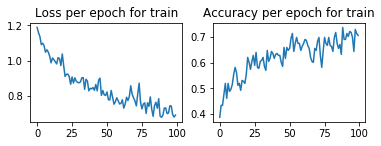

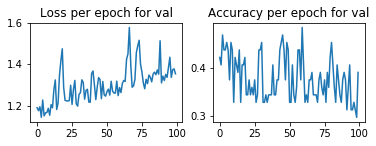

In [6]:
model_conv.train()   
model_conv_ft = train_model(model_conv, criterion, optimizer,
                       num_epochs=100, trainVal=['train','val'])

### 2.2.d) (4 points)
Plot ROC curve of the best model using the dataloader of the test data

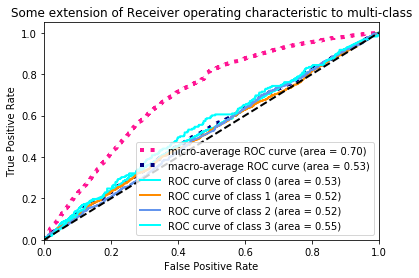

In [7]:
y_s, y_t=inference(model_conv_ft,test_loader)
r_AUC = get_AUC(y_s, y_t, 1)

### 2.2.e) (4 points)
Compute the confusion matrix

Confusion matrix, without normalization
[[1303  313   61    9]
 [1422  426   86    5]
 [ 324   90   20    4]
 [ 164   43    9    2]]


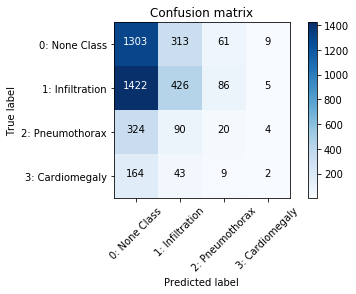

In [8]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t.dot([0,1,2,3]), np.argmax(y_s,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0: None Class','1: Infiltration','2: Pneumothorax','3: Cardiomegaly']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

## 2.3) Loading the pre-trained CNN model, training the model and analyzing results (TL with fine-tuning) 

### 2.3.a) (6 points)
Perform a transfer learning using resnet50 model as a fine-tuning base model (see slide #13 for Lecture 12).
Write the code for designing resnet50 architecture and loading the weights from ImageNet trained network.                                                                       

In [9]:
model_conv_fine_tune = torchvision.models.resnet50(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_fine_tune.fc.in_features
model_conv_fine_tune.fc = torch.nn.Linear(num_ftrs, 4)


### 2.3.b) (4 points)
Define the loss and the optimizer you want to use

In [10]:
if use_gpu:
    model_conv_fine_tune = model_conv_fine_tune.cuda()
    # All model parameters are trained for fine-tuning
    optimizer = torch.optim.SGD(model_conv_fine_tune.parameters(), lr=0.001, momentum=0.9)

criterion = torch.nn.CrossEntropyLoss()

### 2.3.c) (4 points)
Train the model for 100 epochs and save the weights of the best model using the validation loss. Plot train and validation loss curves

Epoch 0/99
----------
train Loss: 1.1923 Acc: 0.4453
val Loss: 1.4161 Acc: 0.3906

Epoch 1/99
----------
train Loss: 1.1435 Acc: 0.4844
val Loss: 1.4990 Acc: 0.3906

Epoch 2/99
----------
train Loss: 1.1619 Acc: 0.4492
val Loss: 1.2623 Acc: 0.3906

Epoch 3/99
----------
train Loss: 1.0694 Acc: 0.4922
val Loss: 1.1153 Acc: 0.4844

Epoch 4/99
----------
train Loss: 1.0566 Acc: 0.5469
val Loss: 1.2391 Acc: 0.4375

Epoch 5/99
----------
train Loss: 0.9729 Acc: 0.5508
val Loss: 1.1760 Acc: 0.4688

Epoch 6/99
----------
train Loss: 0.8844 Acc: 0.6562
val Loss: 1.1879 Acc: 0.4062

Epoch 7/99
----------
train Loss: 0.7883 Acc: 0.6797
val Loss: 1.2167 Acc: 0.4219

Epoch 8/99
----------
train Loss: 0.7404 Acc: 0.7266
val Loss: 1.3233 Acc: 0.3594

Epoch 9/99
----------
train Loss: 0.7311 Acc: 0.6797
val Loss: 1.4810 Acc: 0.4375

Epoch 10/99
----------
train Loss: 0.8113 Acc: 0.6523
val Loss: 1.4451 Acc: 0.3750

Epoch 11/99
----------
train Loss: 0.6698 Acc: 0.7227
val Loss: 1.4656 Acc: 0.4844

Ep

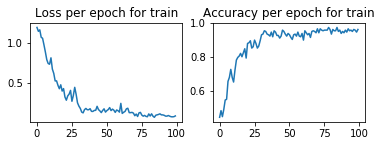

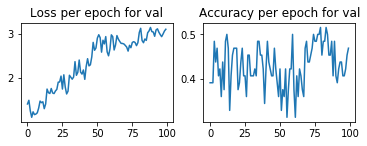

In [11]:
model_conv_fine_tune.train()   
model_conv_fine_tune_ft = train_model(model_conv_fine_tune, criterion, optimizer,
                       num_epochs=100, trainVal=['train','val']) 

### 2.3.d) (4 points)
Plot ROC Curve and confusion matrix

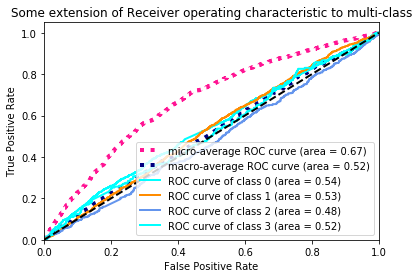

Confusion matrix, without normalization
[[750 735 167  34]
 [773 948 183  35]
 [158 221  41  18]
 [ 92 104  17   5]]


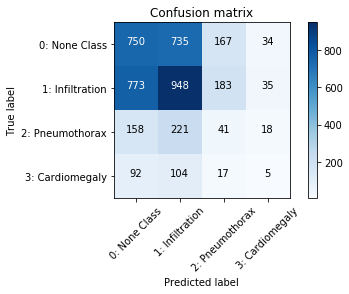

In [12]:
y_s, y_t=inference(model_conv_fine_tune_ft,test_loader)
r_AUC = get_AUC(y_s, y_t, 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t.dot([0,1,2,3]), np.argmax(y_s,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0: None Class','1: Infiltration','2: Pneumothorax','3: Cardiomegaly']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')


### 2.4) (10 points)
Descibe your findings using two different TL approaches that you implemented in Q2.2. and Q2.3. for example what are the differences in terms of speed, accuracy, and so on. 

TL approach used in Q2.2. will be trained faster compared to Q2.3. since in all the layers the gradients will be caluclated and uploaded in each iteration. Q2.3. model training loss decreases in a higher rate compared to Q2.2. model since the number of trainable parameters are much larger......

### 2.5) (10 points) 
In the view of your findings, describe transfer learning approaches we used in this HW in terms of data size and emprical observation domain specifics (Hint: Checkslide # 16 on Lecture #12). What can you do better to improve transfer learning? Propose changes to the current TL strategies. 

we have a small data and very different domain. One way would be to train another classifier from activations somewhere earlier in the network. Or we can train the network from scratch using all the available original data not the random sample that we used in this HW.

### 2.6) Bonus Question (maximum 20 points) 
Implement the changes you proposed in Q2.5 and analyze your results

Answer to this question varies